# Final model performance

In this notebook we run our best-performing model on the test set to get a final estimate of its performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Loading the data

In [2]:
df_train = pd.read_csv('./train_data.csv')
df_test = pd.read_csv('./test_data.csv')

We will now perform some imputation and scaling. It is important to note that all of the transformations we will perform here will be performed "within season," meaning that the data for a given season is transformed using information from ***only*** that season and no other.

In particular, since at the time of prediction we will have access to all of the data for that particular season, there is ***no data leakage*** occurring here.

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

for df in [df_train, df_test]:
    # fill all null stats with 0 (except for SALARY)
    null_cols = df.count()[df.count() < len(df)].index.drop('SALARY')
    df[null_cols] = df[null_cols].fillna(0)

    # use mean imputer for SALARY within each season
    df.loc[df['SALARY']==0, 'SALARY'] = None
    mean_imputer = SimpleImputer(strategy='mean')
    df['SALARY'] = (
        df
        .groupby('SEASON_START')['SALARY']
        .transform(lambda x: mean_imputer.fit_transform(x.values.reshape(-1,1)).ravel())
    )

    # use standard scaler within each season
    cols_to_rescale = df.select_dtypes(include=['float']).columns
    scaler = StandardScaler()
    df[cols_to_rescale] = (
        df
        .groupby('SEASON_START')[cols_to_rescale]
        .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).ravel())
    )

In [4]:
# select features
features = df_train.select_dtypes(include='number').columns.drop(['PLAYER_ID', 'SEASON_START', 'IN_LEAGUE_NEXT'])
print(features)

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY', 'WAIVED', 'RELEASED', 'TRADED', 'WAIVED_OFF',
       'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG',
       'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST'],
      dtype='object')


## Testing model performance

### Performance metrics

We will use the following metrics in our evaluation:

* $\text{Balanced Accuracy} = \frac{\text{Recall} + \text{Specificity}}{2}$

* $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$

* $\text{Recall} = \text{Sensitivity} = \frac{\text{TP}}{\text{TP} + \text{FN}}$

* $\text{Negative Predictive Value (NPV)} = \frac{\text{TN}}{\text{TN} + \text{FN}}$

* $\text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}}$

In [5]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def npv_score(y_true, y_pred):
    tn = ((y_pred == 0) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    return tn / (tn + fn) if (tn + fn) > 0 else 0.0

def specificity_score(y_true, y_pred):
    tn = ((y_pred == 0) & (y_true == 0)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

### Walk-forward testing

In order to get the most realistic estimate of our model performance, we will perform walk-forward testing. The idea is as follows:

0. **Initialize datasets**: Begin with training set `df_train` (seasons 1990-91 through 2016-17) and test set `df_test[df_test['SEASON_START']==2017]` (season 2017-18).

1. **Train the model**: Fit the model using the current training set.

2. **Evaluate performance**: Use the model to predict outcomes for the current test set and compute performance metrics.

3. **Itereate**: Expand the training set to include the current test set, replace the test set with data from the next season, and repeat from Step 1 until no future data is available.

See the following table for explicit details.

| Iteration | Training set start seasons | Test set start season |
| ---       | ---                        | ---                   |
| 1         | 1990 - 2016                | 2017                  |
| 2         | 1990 - 2017                | 2018                  |
| 3         | 1990 - 2018                | 2019                  |
| 4         | 1990 - 2019                | 2020                  |
| 5         | 1990 - 2020                | 2021                  |
| 6         | 1990 - 2021                | 2022                  |

We will write a function `test_model_performance` to implement this walk-forward testing for a given model.

In [6]:
def test_model_performance(model):
    """
    Given a model, computes and prints the following metrics for each test split:
    balanced accuracy, precision, recall, negative predictive value, and specificity.
    Also prints the average of each of these metrics across the test splits and displays
    the sum of the confusion matrices.
    """

    bal_accuracy = []
    precision = []
    recall = []
    npv = []
    specificity = []
    cm = []

    print(f"{'Test Year':<12} {'Bal. Acc.':<12} {'Precision':<12} {'Recall':<12} {'NPV':<12} {'Specificity':<12}")
    print("-" * 76)

    for test_year in range(2017, 2023):
        X_train = pd.concat([df_train[features],
                             df_test.loc[df_test['SEASON_START'] < test_year, features]])
        y_train = pd.concat([df_train['IN_LEAGUE_NEXT'],
                             df_test.loc[df_test['SEASON_START'] < test_year, 'IN_LEAGUE_NEXT']])
        X_test = df_test.loc[df_test['SEASON_START'] == test_year, features]
        y_test = df_test.loc[df_test['SEASON_START'] == test_year, 'IN_LEAGUE_NEXT']

        # fit the model and get predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # get confusion matrix
        conf = confusion_matrix(y_test, y_pred)

        # save and print metrics
        bal_accuracy.append(balanced_accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        npv.append(npv_score(y_test, y_pred))
        specificity.append(specificity_score(y_test, y_pred))
        cm.append(conf)

        print(f"{test_year:<12} "
              f"{balanced_accuracy_score(y_test, y_pred):<12.4f} "
              f"{precision_score(y_test, y_pred):<12.4f} "
              f"{recall_score(y_test, y_pred):<12.4f} "
              f"{npv_score(y_test, y_pred):<12.4f} "
              f"{specificity_score(y_test, y_pred):<12.4f}")

    # print averages of metrics
    print('-' * 76)
    print(f"{'Avg.':<12} "
              f"{np.mean(bal_accuracy):<12.4f} "
              f"{np.mean(precision):<12.4f} "
              f"{np.mean(recall):<12.4f} "
              f"{np.mean(npv):<12.4f} "
              f"{np.mean(specificity):<12.4f}")

    # display total confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=sum(cm)).plot()
    plt.title('Total confusion matrix')
    plt.show()

### Baseline model

As a baseline model, we will consider the classifier which always predicts the majority class, which in this case is 1 (in other words it, always predicts that a player will return to the NBA the folowing year). This model should have a recall of 1 and a specificity of 0, therefore we should expect to see a balanced accuracy of 0.5.

Test Year    Bal. Acc.    Precision    Recall       NPV          Specificity 
----------------------------------------------------------------------------
2017         0.5000       0.7630       1.0000       0.0000       0.0000      
2018         0.5000       0.7547       1.0000       0.0000       0.0000      
2019         0.5000       0.8223       1.0000       0.0000       0.0000      
2020         0.5000       0.8333       1.0000       0.0000       0.0000      
2021         0.5000       0.7157       1.0000       0.0000       0.0000      
2022         0.5000       0.8364       1.0000       0.0000       0.0000      
----------------------------------------------------------------------------
Avg.         0.5000       0.7876       1.0000       0.0000       0.0000      


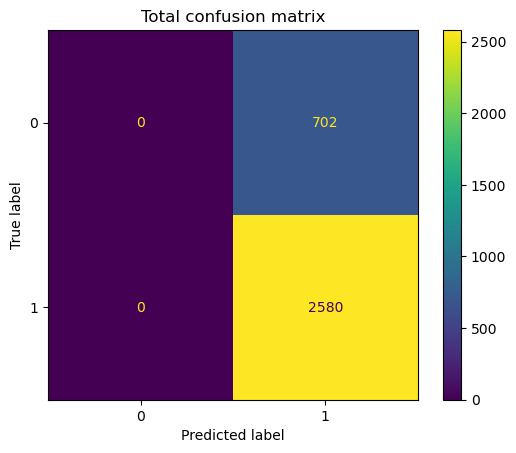

In [7]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy='most_frequent')

test_model_performance(baseline_model)

### Final model: XGBoost with SMOTE

In `3_ModelSelection.ipynb`, we used walk-forward validation to select an XGBoost Classifier (`n_estimators=400` and `learning_rate=0.005`) together with the Synthetic Minority Oversampling Technique (SMOTE) as our final model.

Test Year    Bal. Acc.    Precision    Recall       NPV          Specificity 
----------------------------------------------------------------------------
2017         0.8071       0.9453       0.7549       0.5213       0.8594      
2018         0.8013       0.9251       0.8025       0.5683       0.8000      
2019         0.8007       0.9566       0.7609       0.4317       0.8404      
2020         0.8000       0.9583       0.7667       0.4167       0.8333      
2021         0.8424       0.9330       0.8360       0.6728       0.8488      
2022         0.7926       0.9577       0.7556       0.3989       0.8295      
----------------------------------------------------------------------------
Avg.         0.8073       0.9460       0.7794       0.5016       0.8353      


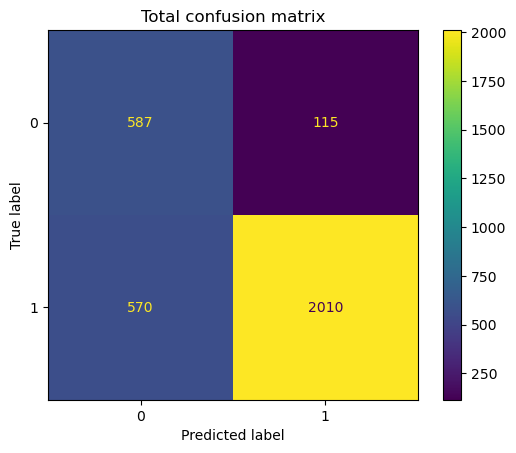

In [8]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

final_model = Pipeline([('smote', SMOTE()), ('xgb', XGBClassifier(n_estimators=400, learning_rate=0.005))])

test_model_performance(final_model)

## Conclusions

**TODO:** write up conclusions, make nice figures, etc.